# 프로젝트 - Class Activation Map을 만들고 평가해보기

CAM (Class Activation Map) : 클래스에 대한 활성화 정도를 나타낸 지도

#### ✔︎ 라이브러리 Setting

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## 1. Dataset 준비하기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='/content/drive/MyDrive/AIFFEL/GoingDeeper/GD 5,6/Dataset')

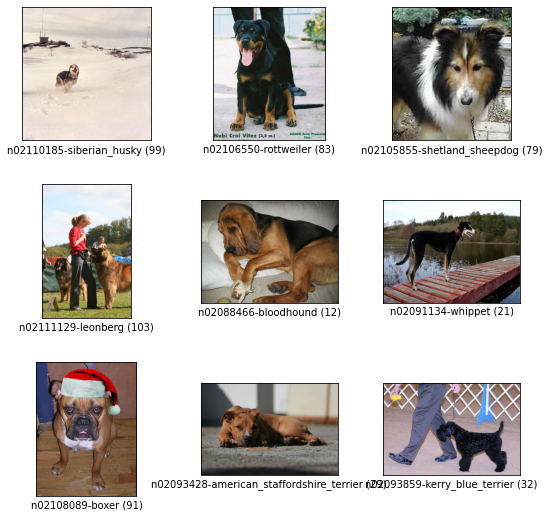

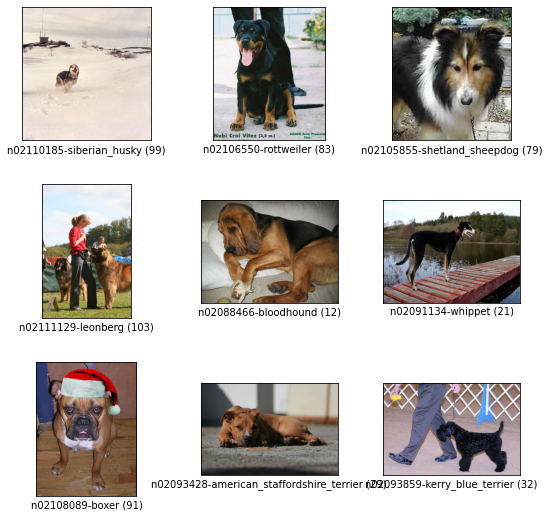

In [4]:
# train 데이터셋 확인
tfds.show_examples(ds_train, ds_info)

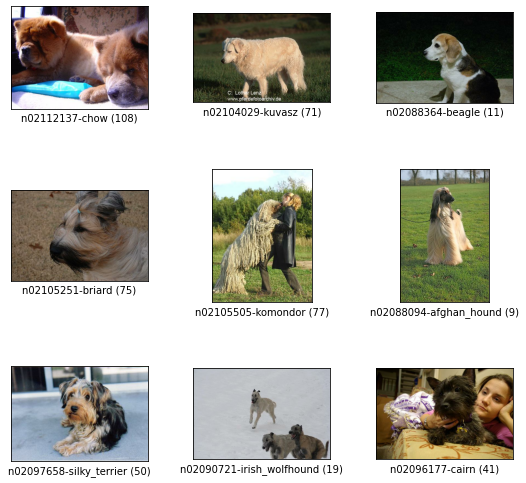

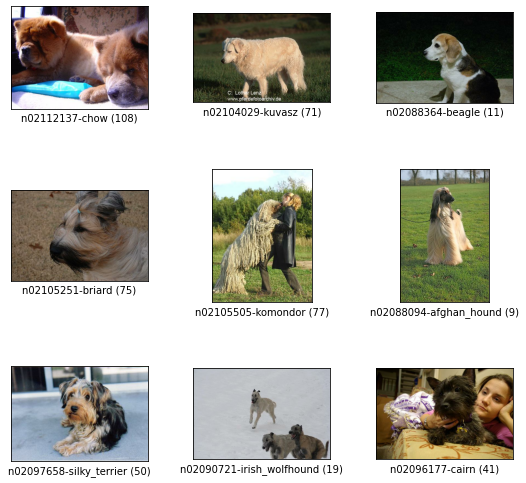

In [5]:
# test 데이터셋 확인
tfds.show_examples(ds_test, ds_info)

In [6]:
# features 어떻게 구성되어 있는지 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

---
## 2. CAM, Grad-CAM용 모델 준비하기

- 미리 이미지넷(Imagenet) 데이터에 훈련된 resnet50을 기반으로, pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들어보겠다.
- 마지막 fully connected layer 대신 Global Average Pooling을 사용해주어야 한다.


In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

- conv5_block3_out의 output이 feature map이 된다. 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 된다.

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

---
## 3. CAM 모델 학습하기

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행하며, 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성해준다.
<br> input에 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 주었다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다.

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# 모델 컴파일
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)


In [12]:
# 모델 훈련
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 123s 142ms/step - loss: 2.1792 - accuracy: 0.4496 - val_loss: 3.4804 - val_accuracy: 0.1827
Epoch 2/15
750/750 [==============================] - 103s 137ms/step - loss: 0.7214 - accuracy: 0.8016 - val_loss: 1.2116 - val_accuracy: 0.6415
Epoch 3/15
750/750 [==============================] - 102s 136ms/step - loss: 0.2952 - accuracy: 0.9329 - val_loss: 0.9850 - val_accuracy: 0.7056
Epoch 4/15
750/750 [==============================] - 102s 136ms/step - loss: 0.0800 - accuracy: 0.9899 - val_loss: 0.8976 - val_accuracy: 0.7368
Epoch 5/15
750/750 [==============================] - 102s 137ms/step - loss: 0.0241 - accuracy: 0.9989 - val_loss: 0.8888 - val_accuracy: 0.7459
Epoch 6/15
750/750 [==============================] - 103s 137ms/step - loss: 0.0126 - accuracy: 0.9999 - val_loss: 0.9090 - val_accuracy: 0.7431
Epoch 7/15
750/750 [==============================] - 102s 136ms/step - loss: 0.0093 - accuracy: 0.9999 - val_loss: 0.9215 -

In [13]:
# 학습시킨 가중치 저장
import os

cam_model_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper/GD 5,6'
cam_model.save(cam_model_path)
print("저장 완료!")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIFFEL/GoingDeeper/GD 5,6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIFFEL/GoingDeeper/GD 5,6/assets


저장 완료!


## 4. CAM, Grad-CAM 적용하기

### 1) CAM

In [15]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='/content/drive/MyDrive/AIFFEL/GoingDeeper/GD 5,6/Dataset')

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 한다.

In [16]:
def get_one(ds): 
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


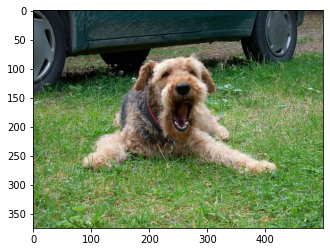

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러온다.

In [18]:
import os
cam_model_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper/GD 5,6'
cam_model = tf.keras.models.load_model(cam_model_path)

In [20]:
# CAM을 생성하는 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)      # 주어진 이미지를 카피해서 저장
    width = item['image'].shape[1]  # 이미지의 사이즈 변수에 저장
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item) # 이미지 정규화
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 모델의 weight activation은 마지막 layer에 있다.
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타남
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()  # 넘파이 배열로 전환
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

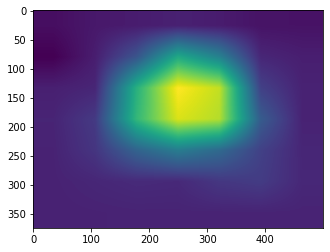

In [21]:
# CAM 이미지 생성
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [23]:
# CAM 이미지를 원본 이미지와 합침
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

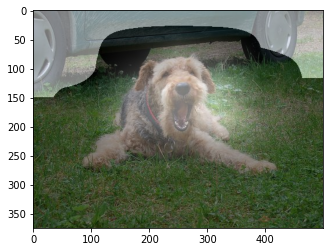

In [24]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### 2) Grad-CAM

관찰 대상 모델은 cam_model 을 그대로 활용한다.

108


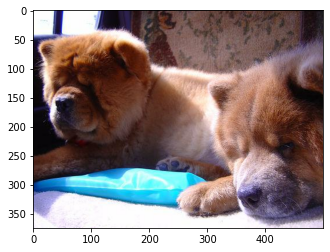

In [25]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 된다.

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용한다.

In [26]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻는다.
        output = conv_output[0] # 원하는 layer의 output을 얻는다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻는다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻는다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

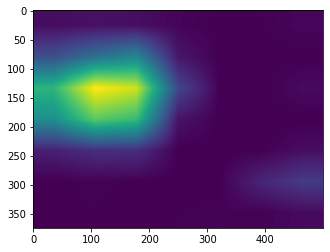

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

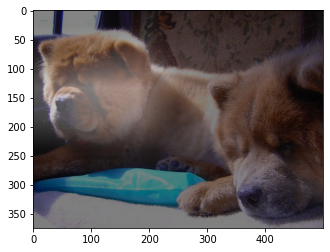

In [31]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

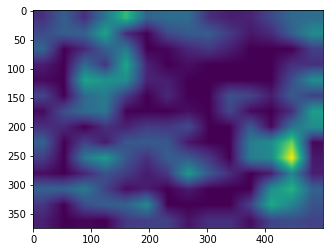

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

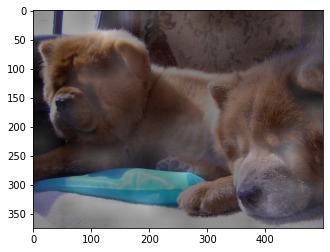

In [33]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

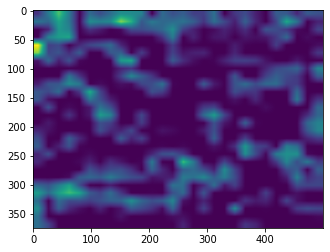

In [34]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

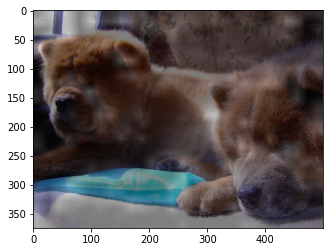

In [35]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

---
## 5. Detection with CAM
### 1) 바운딩 박스
#### CAM에서 물체의 위치를 찾는 detection

67


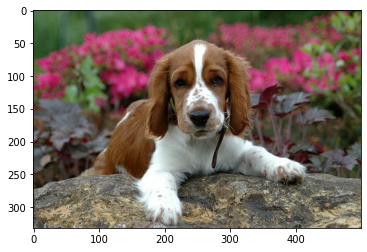

In [36]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

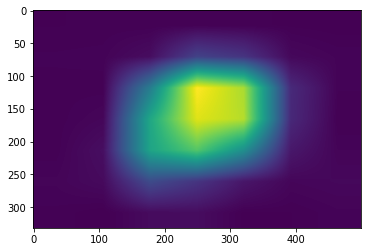

In [37]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다. boxPoints()로 이를 꼭지점으로 바꾸어 준다. 마지막에는 int 자료형으로 변환해준다.

In [38]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [39]:
rect = get_bbox(cam_image)
rect

array([[109, 301],
       [109,  36],
       [434,  36],
       [434, 301]])

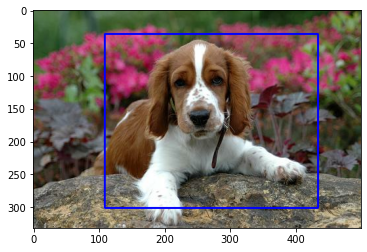

In [40]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### Grad-CAM에서 물체의 위치를 찾는 detection

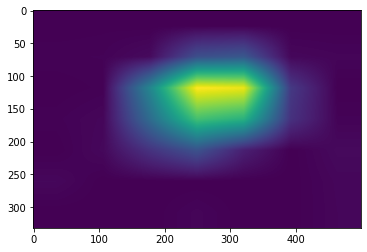

In [41]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [42]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[115, 252],
       [111,  35],
       [440,  30],
       [444, 247]])

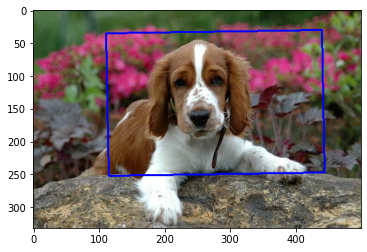

In [43]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

---
## 6. Intersection over Union (IoU)


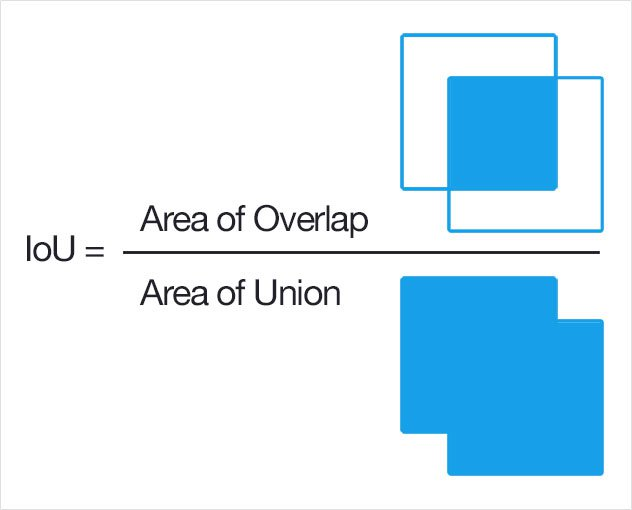

**IoU(Intersection over Union)**는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값이다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [44]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어진다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [45]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.10843373493975904, 0.218, 0.9066265060240963, 0.868]

In [46]:
# 이 데이터의 ground truth bbox
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 얼마나 유사한지를 IoU를 계산해서 확인해보자.

In [47]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [48]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7445776067328527

Grad-CAM 결과와도 확인해보자.

In [49]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.09036144578313253, 0.222, 0.7590361445783133, 0.888]

In [50]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.5808123713825283